In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=299
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10

In [3]:
dataset=image_dataset_from_directory(
   r"F:\project\COVID-19_Radiography_Dataset\manual data",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4533 files belonging to 4 classes.


In [4]:
classes=dataset.class_names
classes

['COVID', 'Viral Pneumonia', 'lung opacity', 'normal']

In [5]:
len(dataset)

142

(32, 299, 299, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 1, 3, 0, 0, 1, 3, 2, 1, 3, 2, 1, 1, 2, 3, 3, 0, 0, 2, 1, 3,
       2, 0, 0, 1, 1, 3, 3, 3, 1, 1])>>


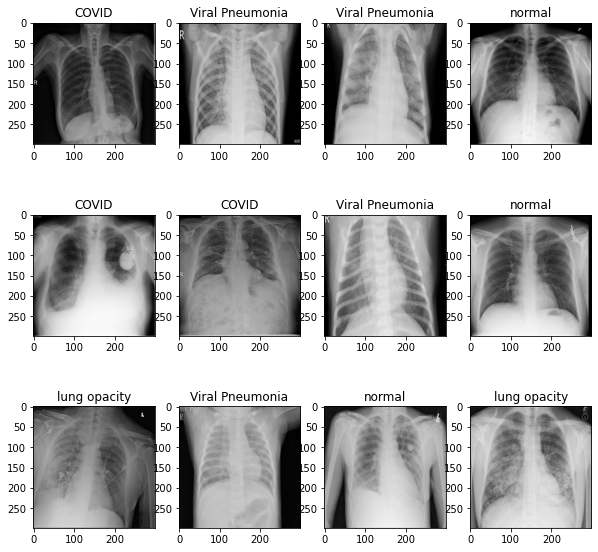

In [6]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy)
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classes[label_batch[i]])

In [7]:
train_ds=dataset.take(50)
len(train_ds)

50

In [8]:
test_ds=dataset.skip(50)
len(test_ds)

92

In [9]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [10]:
tst_ds=test_ds.skip(6)
len(tst_ds)

86

In [11]:
def get_dataset(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shufflesize=10000):
    if shuffle:
        ds=ds.shuffle(shufflesize,seed=12)
    train_size=int(len(ds)*train_split)
    val_size=int(len(ds)*val_split)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [12]:
train_ds,val_ds,test_ds=get_dataset(dataset)
print(len(train_ds),len(val_ds),len(test_ds))

113 14 15


In [13]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [15]:
ip_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=4
model=models.Sequential([
    resize_rescale,
    layers.Conv2D(16,kernel_size=(3,3),activation="relu",input_shape=ip_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3,3),activation="relu",input_shape=ip_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu",input_shape=ip_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation="relu",input_shape=ip_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256,(3,3),activation="relu",input_shape=ip_shape),
    layers.MaxPooling2D((2,2)),
   
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes,activation="softmax")
])
model.build(input_shape=ip_shape)

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 299, 299, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 297, 297, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 148, 148, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 146, 146, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 73, 73, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 71, 71, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 35, 35, 64)         

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1, 
    validation_data=val_ds

)

Epoch 1/10
113/113 [==============================] - 131s 1s/step - loss: 0.9210 - accuracy: 0.6026 - val_loss: 0.7545 - val_accuracy: 0.7076
Epoch 2/10
113/113 [==============================] - 139s 1s/step - loss: 0.4987 - accuracy: 0.8139 - val_loss: 0.4470 - val_accuracy: 0.8326
Epoch 3/10
113/113 [==============================] - 134s 1s/step - loss: 0.3976 - accuracy: 0.8487 - val_loss: 0.3524 - val_accuracy: 0.8728
Epoch 4/10
113/113 [==============================] - 133s 1s/step - loss: 0.3227 - accuracy: 0.8814 - val_loss: 0.3407 - val_accuracy: 0.8638
Epoch 5/10
113/113 [==============================] - 132s 1s/step - loss: 0.2583 - accuracy: 0.9040 - val_loss: 0.2710 - val_accuracy: 0.9174
Epoch 6/10
113/113 [==============================] - 133s 1s/step - loss: 0.2258 - accuracy: 0.9140 - val_loss: 0.2408 - val_accuracy: 0.9085
Epoch 7/10
113/113 [==============================] - 133s 1s/step - loss: 0.1996 - accuracy: 0.9267 - val_loss: 0.2098 - val_accuracy: 0.9330

In [19]:
model.evaluate(test_ds)

15/15 [==============================] - 10s 365ms/step - loss: 0.1859 - accuracy: 0.9542


[0.18590405583381653, 0.9541666507720947]

In [20]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss ')

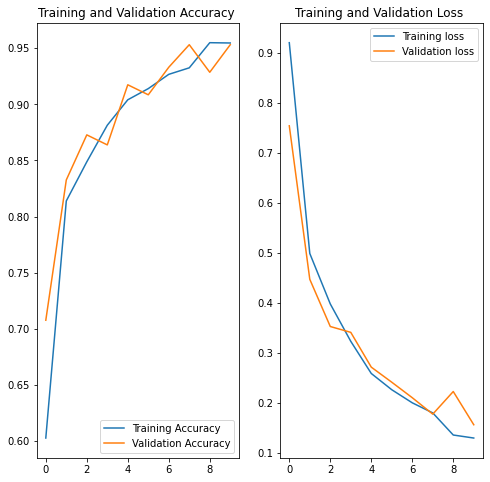

In [21]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy ')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training loss')
plt.plot(range(EPOCHS),val_loss,label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss ')

first image to predict
actual_label=lung opacity
predicted label:lung opacity
first image to predict
actual_label=Viral Pneumonia
predicted label:Viral Pneumonia
first image to predict
actual_label=COVID
predicted label:COVID
first image to predict
actual_label=lung opacity
predicted label:lung opacity
first image to predict
actual_label=COVID
predicted label:COVID
first image to predict
actual_label=normal
predicted label:normal
first image to predict
actual_label=Viral Pneumonia
predicted label:Viral Pneumonia
first image to predict
actual_label=Viral Pneumonia
predicted label:Viral Pneumonia
first image to predict
actual_label=Viral Pneumonia
predicted label:Viral Pneumonia
first image to predict
actual_label=lung opacity
predicted label:lung opacity


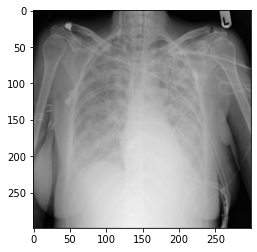

In [22]:
import numpy as np
for images_batch,label_batch in test_ds.take(1):
    for i in range(10):
        first_image=images_batch[i].numpy().astype('uint8')
        first_label=label_batch[i].numpy()
        print("first image to predict")
        plt.imshow(first_image)
        print(f"actual_label={classes[first_label]}")

        batch_prediction=model.predict(images_batch)
        print(f"predicted label:{classes[np.argmax(batch_prediction[i])]}")
        
        

In [24]:
lenet_pred = model.predict_classes(X_test, batch_size=128, verbose=0)
lenet_pred[7]

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [ ]:

sin_labels=np.argmax(y_test, axis=1)
sin_labels[13]

In [ ]:
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(sin_labels, vgg_pred)
cm2

In [ ]:
#Function Calculate Accuracy
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 
print("Accuracy of Model:",accuracy(cm2))